---
### Load Games
---

In [1]:
from pinsdb.bowl.models import Game

In [2]:
all_games = Game.load_games()

2025-01-13 22:46:32.443 | SUCCESS  | pinsdb.bowl.models:load_games:147 - Loaded 390 games from the database


In [ ]:
# for game in games:
#     print(f"{game.bowler.bowler_id=}  {game.game_id=} | {game.score_game()}")
#     print(game.construct_frames())

---
### Reconcile Bowler IDs
---

---
### Plot Visuals
---

#### Summarize DataFrame

In [3]:
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


sample_data = pl.DataFrame(
    [
        {
            "game_id": game.game_id,
            "bowler_id": game.bowler.bowler_id,
            "score": game.score_game(),
            "pins": game.score_pins(),
            "date": game.date,
        }
        for game in all_games
    ]
)

#### Score Dominance

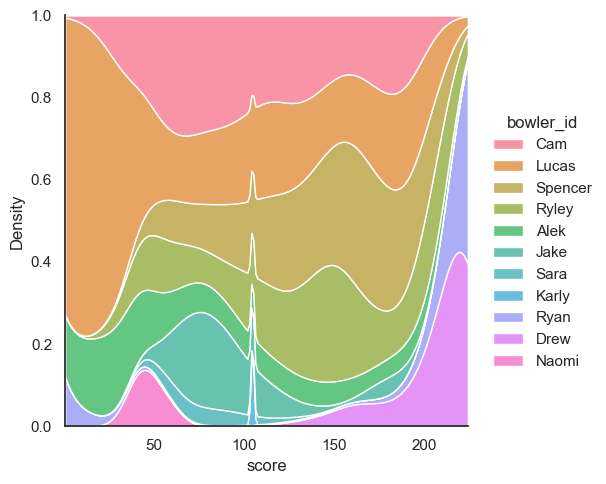

In [4]:
sns.displot(sample_data, x="score", hue="bowler_id", kind="kde", multiple="fill")

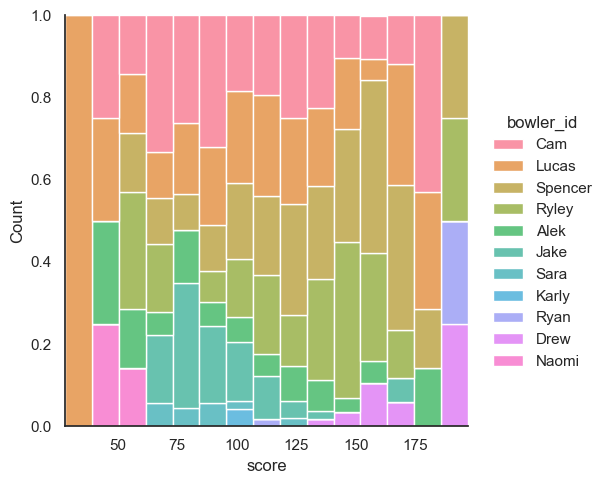

In [5]:
sns.displot(sample_data, x="score", hue="bowler_id", kind="hist", multiple="fill")

In [ ]:
sns.displot(sample_data, x="score", hue="bowler_id", stat="count", kind="ecdf")

#### Score Variance
---

<Axes: xlabel='score', ylabel='bowler_id'>

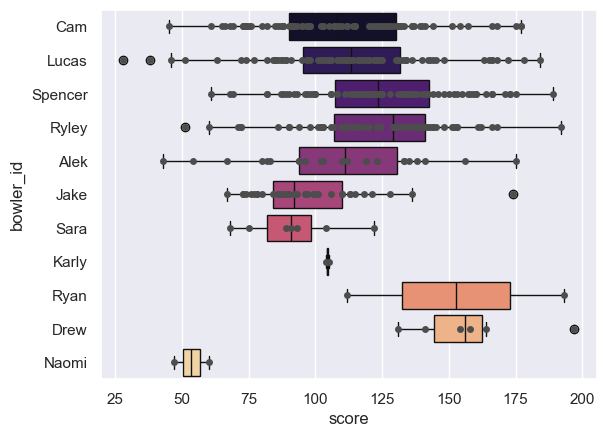

In [6]:
from pinsdb.bowl.bowlers import registered_bowlers

palette = sns.color_palette("magma", n_colors=len(registered_bowlers))
sns.set_theme(style="darkgrid", palette=palette)

sns.boxplot(sample_data, x="score", y="bowler_id", hue="bowler_id", palette=palette)
sns.stripplot(sample_data, x="score", y="bowler_id", color=".3", jitter=0)

#### Pins Ordering

HEATMAP FOR SPENCER


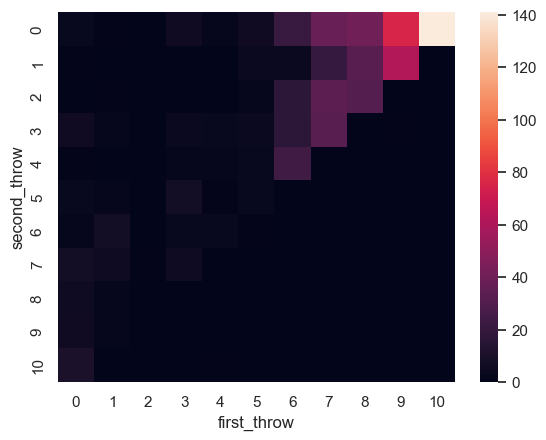

In [19]:
import pandas as pd


for bowler in registered_bowlers[10:11]:
    print(f"HEATMAP FOR {bowler.bowler_id.upper()}")
    throws_data = pd.DataFrame(
        [
            {
                "game_id": game.game_id,
                "bowler_id": game.bowler.bowler_id,
                "frames": game.construct_frames()[:9],
            }
            for game in all_games
            if game.bowler.bowler_id == bowler.bowler_id
        ]
    )
    throws_data = throws_data.explode("frames")
    throws_data[["first_throw", "second_throw"]] = [
        throw + [0] if throw == [10] else throw[:2]
        for throw in throws_data["frames"].to_list()
    ]
    # throws_frequency = pd.DataFrame(throws_data['frames'].value_counts()).reset_index()

    throws_crosstab = pd.crosstab(
        throws_data["second_throw"], throws_data["first_throw"]
    )
    sns.heatmap(throws_crosstab)
    break

#### Ridge Graph

In [ ]:
pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)
ridge_graph = sns.FacetGrid(
    sample_data, row="bowler_id", hue="bowler_id", aspect=15, height=0.5, palette=pal
)
ridge_graph.map(
    sns.kdeplot,
    "score",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5,
)
ridge_graph.map(sns.kdeplot, "score", clip_on=False, color="w", lw=2, bw_adjust=0.5)
ridge_graph.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


ridge_graph.map(label, "score")

# Set the subplots to overlap
ridge_graph.figure.subplots_adjust(hspace=-0.05)

# Remove axes details that don't play well with overlap
ridge_graph.set_titles("")
ridge_graph.set(yticks=[], ylabel="")
ridge_graph.despine(bottom=True, left=True)

In [ ]:
import itertools
import statistics

games_sorted = sorted(all_games, key=lambda g: (g.bowler.bowler_id, g.date, g.game_id))
games_stats = dict()

for group, games in itertools.groupby(games_sorted, key=lambda g: g.bowler.bowler_id):
    games = list(games)
    total_pins = [game.score_pins() for game in games]
    total_points = [game.score_game() for game in games]
    stats = {
        "games": len(games),
        "total_pins": sum([len(game.construct_frames()) * 10 for game in games]),
        "pins": sum(total_pins),
        "points": sum(total_points),
        "mean_pins": round(statistics.mean(total_pins), 1),
        "mean_points": round(statistics.mean(total_points), 1),
        "median_pins": statistics.median(total_pins),
        "median_points": statistics.median(total_points),
    }
    stats["pct_pins"] = round((stats["pins"] / stats["total_pins"]) * 100, 1)
    games_stats[group] = (
        pl.DataFrame(stats)
        .unpivot()
        .with_columns(bowler=pl.lit(group))
        .select("bowler", "variable", "value")
    )

games_data = pl.concat(games_stats.values())

In [ ]:
g = sns.barplot(
    games_data.filter(pl.col("variable").is_in(["total_pins", "pins", "points"])),
    x="variable",
    y="value",
    hue="bowler",
)
sns.move_legend(
    g, "lower center", bbox_to_anchor=(0.5, 1), ncol=len(registered_bowlers), title=None
)

In [ ]:
g = sns.barplot(
    games_data.filter(~pl.col("variable").is_in(["total_pins", "pins", "points"])),
    x="variable",
    y="value",
    hue="bowler",
)
sns.move_legend(
    g, "lower center", bbox_to_anchor=(0.5, 1), ncol=len(registered_bowlers), title=None
)

#### Score Over Time

In [ ]:
strip_data = (
    sample_data.group_by("bowler_id")
    .agg(
        max_score=pl.col("score").max(),
        min_score=pl.col("score").min(),
        # max_pins=pl.col("pins").max(),
        # min_pins=pl.col("pins").min(),
    )
    .unpivot(index="bowler_id")
    .sort("value", descending=True)
)

sns.pointplot(strip_data, x="value", y="bowler_id", hue="bowler_id", estimator="max")
sns.stripplot(
    strip_data,
    x="value",
    y="bowler_id",
    hue="bowler_id",
    jitter=0,
)

In [ ]:
g = sns.relplot(sample_data, x="date", y="score", hue="bowler_id", kind="line")
sns.move_legend(
    g, "lower center", bbox_to_anchor=(0.5, 1), ncol=len(registered_bowlers), title=None
)